In [1]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.8/615.8 KB 42.5 MB/s eta 0:00:00


# Preprocessing & Model architecture

In [1]:
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds

import datetime
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# from sklearn.manifold import TSNE

#import mnist data
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def augment(x, y):
    image = tf.image.random_brightness(x, max_delta=0.05)
    return image, y

def preprocess(data, noise_var=0.5):
    # use only the images
    data = data.map(lambda x, t: tf.cast(x, tf.dtypes.float32))
    # normalize images
    data = data.map(lambda x: ((x / 128.)-1.))
    # add noise to images
    noise = noise_var * tf.random.normal(shape=(28, 28, 1))
    data = data.map(lambda o_img: (o_img + noise, o_img))
    # clip values to range of [-1,1]
    data = data.map(lambda n_img, o_img: (tf.clip_by_value(n_img, clip_value_min=-1, clip_value_max=1), o_img))
    # cache, shuffle, batch, prefetch
    data = data.cache()
    data = data.shuffle(2000)
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

class CNN_Encoder(tf.keras.layers.Layer):
    def __init__(self, dropout_rate):
        super(CNN_Encoder, self).__init__()
        # Img size: 28x28x1
        self.conv1 = tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=(2, 2), padding='same',
                                            activation='relu', kernel_regularizer=tf.keras.regularizers.L2)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        # Img size: 14x14x4
        self.conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(2, 2), padding='same',
                                            activation='relu', kernel_regularizer=tf.keras.regularizers.L2)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm2 = tf.keras.layers.BatchNormalization(axis=-1)
        # Img size: 7x7x8
        self.flatten = tf.keras.layers.Flatten()
        # Img size: 1x1x392
        self.batch_norm1 = tf.keras.layers.BatchNormalization(axis=-1)
        self.out = tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L2)
        # Img size: 10

    def call(self, x, training):
        #print(x.shape)
        x = self.conv1(x, training=training)
        x = self.dropout1(x, training=training)
        #print(x.shape)
        x = self.conv2(x, training=training)
        x = self.dropout2(x, training=training)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.batch_norm1(x, training=training)
        x = self.out(x)
        #print(x.shape)
        return x


class CNN_Decoder(tf.keras.layers.Layer):
    def __init__(self, dropout_rate):
        super(CNN_Decoder, self).__init__()
        # Restore dimensionality
        self.dim_restore = tf.keras.layers.Dense(392, activation='relu', kernel_regularizer=tf.keras.regularizers.L2)
        # Img size: 1x1x3136
        self.reshape = tf.keras.layers.Reshape((7, 7, 8))
        # Img size: 7x7x8
        self.convTranspose1 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=(2, 2), padding='same',
                                                              activation='relu', kernel_regularizer=tf.keras.regularizers.L2)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        # Img size: 14x14x4
        self.convTranspose2 = tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same',
                                                              activation='relu', kernel_regularizer=tf.keras.regularizers.L2)
        self.dropout4 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm2 = tf.keras.layers.BatchNormalization(axis=-1)
        # Img size: 28x28x4
        self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1),
                                          padding='same')
        # Img size: 28x28x1

    def call(self, x, training):
        x = self.dim_restore(x)
        #print(x.shape)
        x = self.reshape(x)
        #print(x.shape)
        x = self.convTranspose1(x, training=training)
        x = self.dropout3(x, training=training)
        #print(x.shape)
        x = self.convTranspose2(x, training=training)
        x = self.dropout4(x, training=training)
        x = self.batch_norm2(x, training=training)
        #print(x.shape)
        x = self.out(x)
        #print(x.shape)
        return x

class CNN_Autoencoder(tf.keras.Model):
    def __init__(self, dropout_rate=0.5):
        super(CNN_Autoencoder, self).__init__()
        # Layers
        self.encoder = CNN_Encoder(dropout_rate)
        self.decoder = CNN_Decoder(dropout_rate)

        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        # Loss function
        self.loss_function = tf.keras.losses.MeanSquaredError()
        # Metrics
        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.Accuracy(name="accuracy")]

    def call(self, x, training):
        x = self.encoder(x, training=training)
        x = self.decoder(x, training=training)
        return x

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update loss metric
        self.metrics[0].update_state(loss)
        for metric in self.metrics[1:]:
            metric.update_state(label, output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        img, label = data

        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # update loss metric
        self.metrics[0].update_state(loss)
        for metric in self.metrics[1:]:
            metric.update_state(label, output)
        return {m.name: m.result() for m in self.metrics}

    def predict(self, data):
        img, label = data
        return self(img, training=False)

def metric_before_epoch(model, train_ds, test_ds, train_summary_writer, test_summary_writer):
    print("\n")
    print("Loss and accuracy before training:")

    for data in tqdm.tqdm(train_ds, position=0, leave=True):
        metrics = model.test_step(data)


        with train_summary_writer.as_default():
            for metric in model.metrics:
                tf.summary.scalar(f"{metric.name}", metric.result(), step=1)

    # print the metrics
    print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

    # reset all metrics
    model.reset_metrics()

    for data in tqdm.tqdm(test_ds, position=0, leave=True):
        metrics = model.test_step(data)

        # logging the validation metrics to the log file which is used by tensorboard
        with test_summary_writer.as_default():
            for metric in model.metrics:
                tf.summary.scalar(f"{metric.name}", metric.result(), step=1)

    print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])

    # reset all metrics
    model.reset_metrics()
    print("\n")

def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer):
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")

        # Training
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()

        # Validation
        for data in test_ds:
            metrics = model.test_step(data)

            # logging the validation metrics to the log file which is used by tensorboard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
        print("\n")

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


# Main

Tensor shape =  (32, 28, 28, 1) (32, 28, 28, 1)


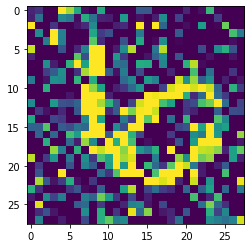

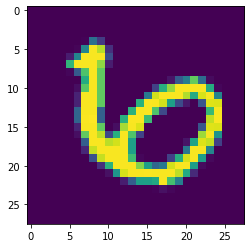



Loss and accuracy before training:


100%|██████████| 1875/1875 [00:54<00:00, 34.20it/s]


['train_loss: 0.9189602732658386', 'train_accuracy: 0.0']


100%|██████████| 313/313 [00:10<00:00, 30.54it/s]


['test_loss: 0.9199583530426025', 'test_accuracy: 0.0']


Epoch 0:


100%|██████████| 1875/1875 [01:21<00:00, 22.89it/s]


['train_loss: 0.25935491919517517', 'train_accuracy: 1.4880951937357167e-07']
['test_loss: 0.17127038538455963', 'test_accuracy: 0.0']


Epoch 1:


100%|██████████| 1875/1875 [01:08<00:00, 27.36it/s]


['train_loss: 0.1478741317987442', 'train_accuracy: 8.503401005555133e-08']
['test_loss: 0.13859021663665771', 'test_accuracy: 0.0']


Epoch 2:


100%|██████████| 1875/1875 [01:21<00:00, 22.89it/s]


['train_loss: 0.13828009366989136', 'train_accuracy: 2.1258502513887834e-08']
['test_loss: 0.13573835790157318', 'test_accuracy: 0.0']


Epoch 3:


100%|██████████| 1875/1875 [01:21<00:00, 22.89it/s]


['train_loss: 0.13415735960006714', 'train_accuracy: 2.1258502513887834e-08']
['test_loss: 0.1269233375787735', 'test_accuracy: 1.2755101863604068e-07']


Epoch 4:


100%|██████████| 1875/1875 [01:06<00:00, 28.01it/s]


['train_loss: 0.1318015307188034', 'train_accuracy: 0.0']
['test_loss: 0.12554562091827393', 'test_accuracy: 0.0']


Epoch 5:


100%|██████████| 1875/1875 [01:07<00:00, 27.63it/s]


['train_loss: 0.13096284866333008', 'train_accuracy: 2.1258502513887834e-08']
['test_loss: 0.12335719168186188', 'test_accuracy: 0.0']


Epoch 6:


100%|██████████| 1875/1875 [01:07<00:00, 27.70it/s]


['train_loss: 0.13046075403690338', 'train_accuracy: 3.8265307011897676e-07']
['test_loss: 0.11608267575502396', 'test_accuracy: 0.0']


Epoch 7:


100%|██████████| 1875/1875 [01:07<00:00, 27.61it/s]


['train_loss: 0.1298627108335495', 'train_accuracy: 2.1258502513887834e-08']
['test_loss: 0.12197299301624298', 'test_accuracy: 0.0']


Epoch 8:


100%|██████████| 1875/1875 [01:08<00:00, 27.19it/s]


['train_loss: 0.12971192598342896', 'train_accuracy: 2.1258502513887834e-08']
['test_loss: 0.1211848258972168', 'test_accuracy: 0.0']


Epoch 9:


100%|██████████| 1875/1875 [01:07<00:00, 27.76it/s]


['train_loss: 0.1292724460363388', 'train_accuracy: 0.0']
['test_loss: 0.11649703979492188', 'test_accuracy: 0.0']




In [3]:

##################### Set paths ################
if os.path.exists('/content/drive/MyDrive/logs/'):
    from google.colab import drive
    path = '/content/drive/MyDrive/logs/Autoencoder'
    drive.mount(path)
else:
    path = 'C:/Users/accou/OneDrive/Desktop/Arbeit/Studium/Master/Semester03/IANNwTF/Week08/logs'

################## Preprocess the data ############
# determine noisiness
NOISE = 1
train_data = preprocess(train_ds, noise_var=NOISE)
# augment data
train_data = train_data.map(augment)
test_data = preprocess(test_ds, noise_var=NOISE)

# show noisy image
for n_img, o_img in train_data.take(1):
    print("Tensor shape = ", n_img.shape, o_img.shape)

    x = np.asarray(n_img[0, :, :, 0])
    t = np.asarray(o_img[0, :, :, 0])
    plt.imshow(x)
    plt.show()
    #plt.savefig('preprocessed_noisy_img.png', format='png')
    plt.imshow(t)
    plt.show()
    #plt.savefig('preprocessed_original_img.png', format='png')

# create model
DROPOUT=0.2
model = CNN_Autoencoder(dropout_rate=DROPOUT)

# Define where to save the log
config_name = "Autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"{path}/{config_name}/{current_time}/train"
test_log_path = f"{path}/{config_name}/{current_time}/test"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)

metric_before_epoch(model=model,
                train_ds=train_data,
                test_ds=test_data,
                train_summary_writer=train_summary_writer,
                test_summary_writer=test_summary_writer)

training_loop(model=model,
                train_ds=train_data,
                test_ds=test_data,
                epochs=10,
                train_summary_writer=train_summary_writer,
                test_summary_writer=test_summary_writer)

# Latent space analysis

In [4]:
from sklearn.manifold import TSNE

# initialize encoder as model_E
model_E = model.encoder

def preprocess_w_labels(data, noise_var=0.5):
    # use only the images
    data = data.map(lambda x, t: (tf.cast(x, tf.dtypes.float32), t))
    # normalize images
    data = data.map(lambda x, t: (((x / 128.)-1.), t))
    
    # add noise to images
    noise = noise_var * tf.random.normal(shape=(28, 28, 1))
    data = data.map(lambda x, t: (x + noise, t))
    # clip values to range of [-1,1]
    data = data.map(lambda x, t: (tf.clip_by_value(x, clip_value_min=-1, clip_value_max=1), t))
    # cache, shuffle, batch, prefetch
    data = data.cache()
    data = data.shuffle(2000)
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

#create labeled dataset
val_data = preprocess_w_labels(test_ds, noise_var=1)

# take 32 datasets (aka 1024 images because we have a batch size of 32) 
var = val_data.take(32)
img = []
label = []
for x, t in var:
    img.append(model_E(x))
    label.append(t)

# concat on batch axis and convert to numpy array
img = tf.concat(img, axis=0)
img = img.numpy()
label = tf.concat(label, axis=0)
label = label.numpy()

# build t-SNE
tsne_img = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(img)
tsne_img.shape

(1024, 2)

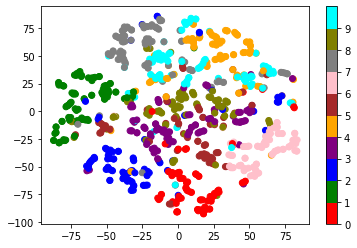

In [8]:
import matplotlib
# plot t-SNE
colors = ['red','green','blue','purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
plt.scatter(tsne_img[:,0], tsne_img[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(['0','1','2','3','4','5','6','7','8','9'])